<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M6_NB_MiniProject_3_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [2]:
!pip3 install imageio==2.4.1

In [3]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

A
replace Actions/train/Walking/person01_walking_d1_uncomp.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset downloaded successfully!!


### Import required packages

In [4]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [5]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
# YOUR CODE HERE
IMG_SIZE = 224

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

# frames = {}
# for path in glob.iglob(data_dir + "**/*.avi", recursive=True):
#     action = path.split('/')[4]
#     frame = load_video(path)
#     if action not in frames:
#         frames[action] = frame
#     frames[action].append(frame)


# test_frames = {}
# for path in glob.iglob(test_data_dir + "**/*.avi", recursive=True):
#     action = path.split('/')[4]
#     if action not in test_frames:
#         frame = load_video(path)
#     frames[action].append(frame)

def get_frames_for_data_file(data_directory):
    frames = {}
    for path in glob.iglob(data_directory + "**/*.avi", recursive=True):
        action = path.split('/')[4]
        frame = load_video(path)
        if action not in frames:
            frames[action] = []
        frames[action].append(frame)
    return frames

data_frames = get_frames_for_data_file(data_dir)
test_frames = get_frames_for_data_file(test_data_dir)

In [6]:
data_frames.keys()

dict_keys(['handwaving', 'Handclapping', 'running', 'Walking', 'boxing', 'jogging'])

In [7]:
for key,value in data_frames.items():
    print(key,value[0].shape)

handwaving (562, 224, 224, 3)
Handclapping (443, 224, 224, 3)
running (510, 224, 224, 3)
Walking (666, 224, 224, 3)
boxing (360, 224, 224, 3)
jogging (612, 224, 224, 3)


array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [246, 246, 246],
        [247, 247, 247],
        [248, 248, 248]],

       [[251, 251, 251],
        [250, 250, 250],
        [248, 248, 248],
        ...,
        [243, 243, 243],
        [244, 244, 244],
        [244, 244, 244]],

       [[247, 247, 247],
        [245, 245, 245],
        [241, 241, 241],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       ...,

       [[218, 218, 218],
        [218, 218, 218],
        [218, 218, 218],
        ...,
        [195, 195, 195],
        [196, 196, 196],
        [196, 196, 196]],

       [[204, 204, 204],
        [203, 203, 203],
        [200, 200, 200],
        ...,
        [185, 185, 185],
        [195, 195, 195],
        [200, 200, 200]],

       [[196, 196, 196],
        [194, 194, 194],
        [191, 191, 191],
        ...,
        [179, 179, 179],
        [194, 194, 194],
        [203, 203, 203]]], dtype=uint8)
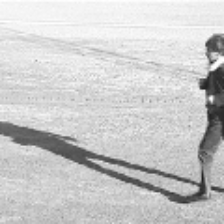

In [8]:
key = 'jogging'
data_frames[key][0][int(round(len(data_frames[key]))/2)]

#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

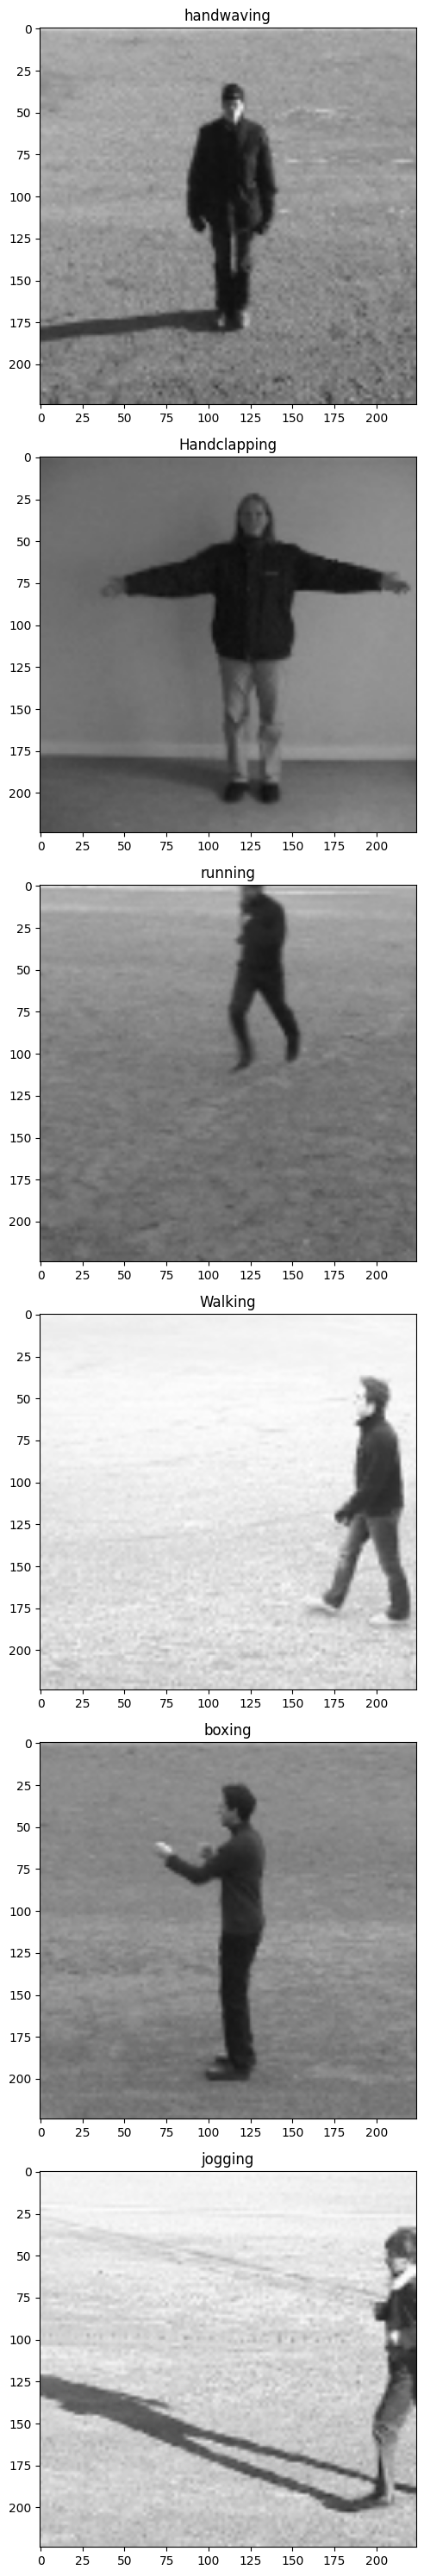

In [9]:
# YOUR CODE HERE
fig,ax = plt.subplots(6, 1, figsize=(30, 30))
for i,key in enumerate(data_frames.keys()):
    # ax[i].imshow(frames[key][0])
    ax[i].imshow(data_frames[key][0][int(round(len(data_frames[key]))/2)])
    ax[i].set_title(key)

# for key,value in frames.items():
#     plt.title(key)
#     plt.plot(value[round(len(value)/2)])

plt.tight_layout()


### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [10]:
# YOUR CODE HERE
def create_feature_extractor():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    return model

feature_extractor = create_feature_extractor()
feature_extractor.summary()

def create_classifier(feature_extractor, use_gru=True, use_lstm=False):
    model = Sequential()
    model.add(TimeDistributed(feature_extractor, input_shape=(None, 224, 224, 3)))
    if use_gru:
        model.add(GRU(64, return_sequences=False))
    if use_lstm:
        model.add(LSTM(64, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    return model

classifier_model = create_classifier(feature_extractor, use_gru=True, use_lstm=False)
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [11]:
from tensorflow.keras.utils import to_categorical
import random

def select_random_frames(data_frames_random, num_frames=50):
    """Selects a random number of frames from each video of each action class.

    Args:
        data_frames: A dictionary of video frames, where the keys are the action classes and the values are lists of video frames.
        num_frames: The number of frames to select from each video.

    Returns:
        A dictionary of selected video frames, where the keys are the action classes and the values are lists of selected video frames.
    """
    selected_frames = {}
    for action, video_frames_list in data_frames_random.items():
        selected_frames[action] = []
        for video_frames in video_frames_list:
            # Randomly select frames from the video
            if len(video_frames) >= num_frames:
                selected_frames[action].append(random.sample(list(video_frames), num_frames))
            else:
                # If the video has fewer frames than num_frames, use all frames.
                selected_frames[action].append(video_frames)
    return selected_frames

# Select 50 frames from each video of each action class
data_frames_50 = select_random_frames(data_frames, num_frames=20)
test_frames_50 = select_random_frames(test_frames, num_frames=20)

def prepare_data_for_training(data_50, feature_extractor):
    """Prepares data for training the classifier model.

    Args:
        data_frames_50: A dictionary of selected video frames.
        feature_extractor: The feature extraction model.

    Returns:
        X: The feature vectors for the selected frames.
        y: The one-hot encoded labels for the selected frames.
    """
    features = []
    labels = []
    action_classes = list(data_50.keys())  # Get the list of action classes

    for action, video_frames_list in data_50.items():
        for video_frames in video_frames_list:
            video_features = []
            for frame in video_frames:  # Iterate through the selected frames
                frame_features = feature_extractor.predict(np.expand_dims(frame, axis=0))
                video_features.append(frame_features)  # Append frame features to video features
            features.append(video_features)  # Append video features to overall features
            labels.append(action_classes.index(action))  # Append the label for the video

    # Convert to NumPy arrays
    X = np.array(features)
    y = np.array(labels)

    # One-hot encode labels
    y = to_categorical(y, num_classes=len(action_classes))

    return X, y


def get_data(data):
    # 1. Extract features and create sequences
    features = []
    labels = []
    # sequences = []
    # sequence_length = 10
    # img_size = (224, 224)
    action_classes = list(data.keys())

    for action, video_frames_list in data.items():
        for video_frames in video_frames_list:
            video_features = []
            selected_frames = video_frames[::4]
            for frame in selected_frames:
                frame_features = feature_extractor.predict(np.expand_dims(frame, axis=0))
                video_features.append(frame_features)
            features.append(video_features)
            labels.append(action_classes.index(action))

    # 2. Convert to NumPy arrays
    X = np.array(features)
    y = np.array(labels)
    # X = np.array(sequences)
    # for action, video_frames_list in data.items():
    #     for video_frames in video_frames_list:
    #         # Pad or truncate video frames to sequence length
    #         if len(video_frames) < sequence_length:
    #             num_padding_frames = sequence_length - len(video_frames)
    #             padding_frames = [np.zeros(img_size + (3,)) for _ in range(num_padding_frames)]
    #             video_frames = np.concatenate([video_frames, padding_frames])
    #         elif len(video_frames) > sequence_length:
    #             video_frames = video_frames[:sequence_length]

    #         # Resize frames
    #         video_frames = [cv2.resize(frame, img_size) for frame in video_frames]

    #         # Normalize frames
    #         video_frames = np.array(video_frames) / 255.0

    #         sequences.append(video_frames)
    #         labels.append(action_classes.index(action))

    # 3. One-hot encode labels
    y = to_categorical(y, num_classes=len(action_classes))

    # 4. Split into train and test sets
    # if validation:
    #     return X, y
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # return X_train, X_test, y_train, y_test
    return X, y

def prepare_data_without_feature_extraction(data_frames_50):
    """Prepares data for processing without feature extraction.

    Args:
        data_frames_50: A dictionary of selected video frames.

    Returns:
        X: A NumPy array of shape (num_videos, num_frames, 224, 224, 3) containing the selected frames.
        y: The one-hot encoded labels for the videos.
    """
    X = []
    y = []
    action_classes = list(data_frames_50.keys())

    for action, video_frames_list in data_frames_50.items():
        for video_frames in video_frames_list:
            X.append(np.array(video_frames))  # Append the video frames directly
            y.append(action_classes.index(action))  # Append the label for the video

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # One-hot encode labels
    y = to_categorical(y, num_classes=len(action_classes))

    return X, y

In [12]:
# Prepare the data
X_train, y_train = prepare_data_without_feature_extraction(data_frames_50)
X_validation, y_validation = prepare_data_without_feature_extraction(test_frames_50)

In [ ]:
# X_train,y_train = get_data(data_frames)
# X_validation, y_validation = get_data(test_frames)
# X_train, y_train = prepare_data_for_training(data_frames_50, feature_extractor)
# X_validation, y_validation = prepare_data_for_training(test_frames_50, feature_extractor)

In [13]:
classifier_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [20]:
(frames,rows,columns,channels)=X_train.shape[1:]

In [21]:
channels

3

In [15]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE
history = classifier_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/5
15/15 [==============================] - 780s 52s/step - loss: 1.9756 - accuracy: 0.1733 - val_loss: 1.7989 - val_accuracy: 0.1667
Epoch 2/5
15/15 [==============================] - 766s 51s/step - loss: 1.9313 - accuracy: 0.1336 - val_loss: 1.7938 - val_accuracy: 0.1667
Epoch 3/5
15/15 [==============================] - 767s 51s/step - loss: 1.8402 - accuracy: 0.1754 - val_loss: 1.7931 - val_accuracy: 0.1667
Epoch 4/5
15/15 [==============================] - 766s 51s/step - loss: 1.8365 - accuracy: 0.1503 - val_loss: 1.7921 - val_accuracy: 0.1667
Epoch 5/5
15/15 [==============================] - 769s 51s/step - loss: 1.8206 - accuracy: 0.1608 - val_loss: 1.7923 - val_accuracy: 0.1667


### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [34]:
# YOUR CODE HERE
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
# from keras.layers.pooling import GlobalAveragePooling2D
# from keras.layers.recurrent import LSTM
# from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam


video = Input(shape=(frames,
                     rows,
                     columns,
                     channels))

classes = 6
# Permute the dimensions of the video input to match the expected shape
# of the CNN (batch_size, frames, height, width, channels)
# video_permuted = Permute((1, 3, 4, 2))(video)

cnn_base = VGG16(input_shape=(rows,
                              columns,
                              channels),
                 weights="imagenet",
                 include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False
encoded_frames = TimeDistributed(cnn)(video)
# encoded_frames = TimeDistributed(cnn)(video_permuted)
encoded_sequence = LSTM(256)(encoded_frames)
hidden_layer = Dense(units=1024, activation="relu")(encoded_sequence)
outputs = Dense(units=classes, activation="softmax")(hidden_layer)
model = Model([video], outputs)
optimizer = Nadam(learning_rate=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"])

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# YOUR CODE HERE
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/5
 8/15 [===============>..............] - ETA: 13:33 - loss: 1.3882 - categorical_accuracy: 0.3672

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification